In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load
from glob import glob

In [3]:
def get_agent_playthroughs(config, allow_empty_link):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_') and str(allow_empty_link) in filename:
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [4]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def heatmap(playthrough_data, graph, filename, bounds):
    max_x, max_y = bounds
    data = np.zeros((max_x + 1, max_y + 1))
    mask = np.ones((max_x + 1, max_y + 1))
    for n in graph.nodes:
        if '__' in n:
            continue
            
        a,b,_ = n.split(',')
        mask[int(a)][int(b)] = 0.0
    
    for run in playthrough_data:
        for segment, _, _, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1.0
    
    sns.set(rc = {'figure.figsize':(8,4)})
    ax = sns.heatmap(
        data, 
        mask=mask,
        square=True,
        cmap='Blues'
    )
#     ax = sns.heatmap(data, square=True)
    ax.invert_yaxis()
    ax.set_title(filename)
    ax.set_facecolor("gray")
    
    # reduce frequency for xticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # reduce frequency for y ticks
    for ind, label in enumerate(ax.get_yticklabels()):
        if ind % 5 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.show()

In [6]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-2]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data)
    ax.set_title('Reward over Time')
        
    plt.show()

## Agent :: DungeonGrams

In [7]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


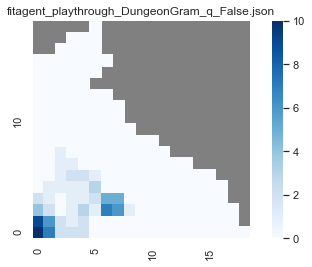

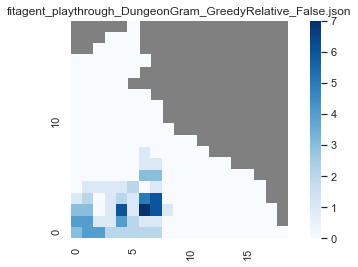

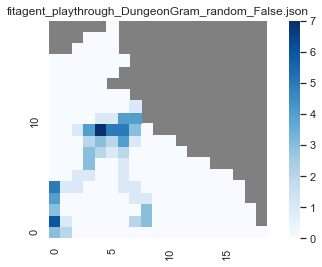

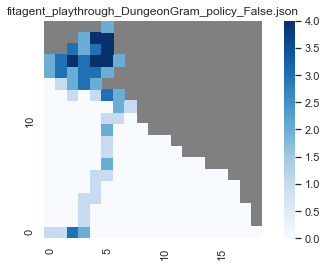

In [8]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

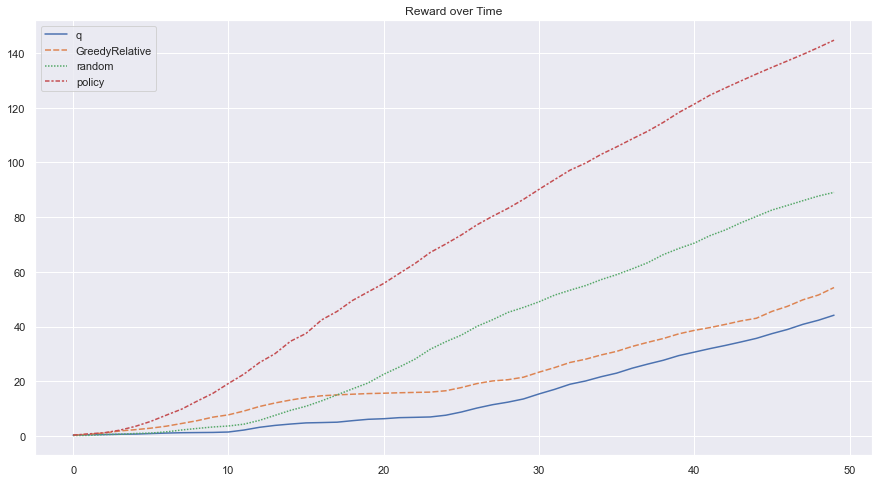

In [9]:
plot_reward_over_time(playthroughs)

## Agent :: DungeonGrams + Food

In [10]:
config = DungeonGrams
graph = Utility.get_graph(config, False)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_False.json


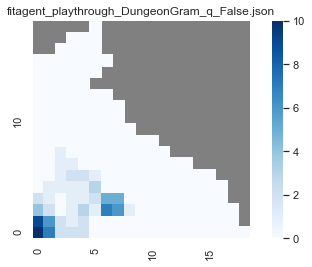

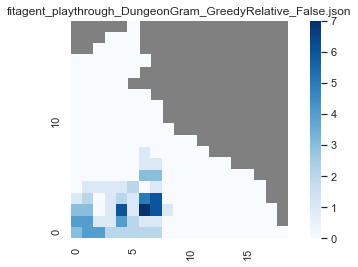

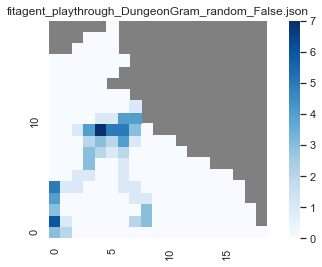

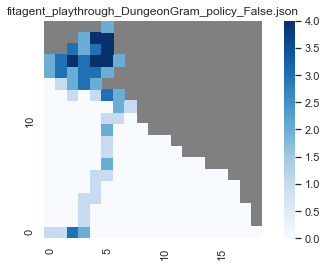

In [11]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

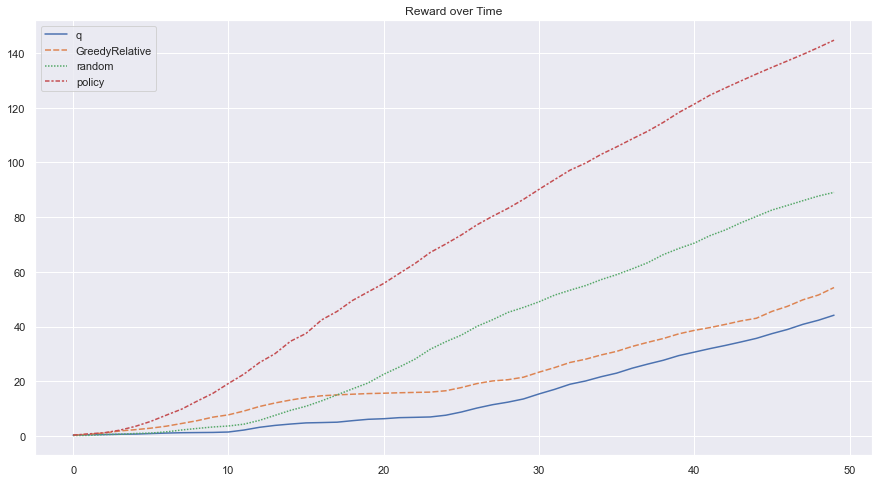

In [12]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [13]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


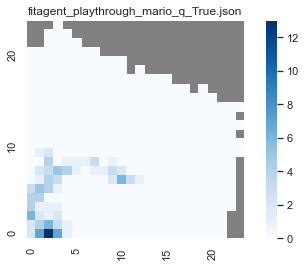

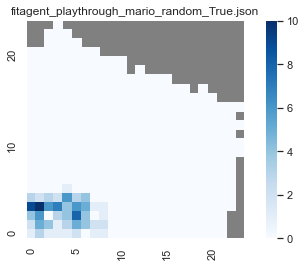

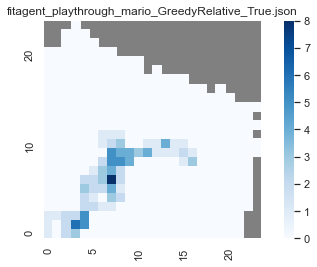

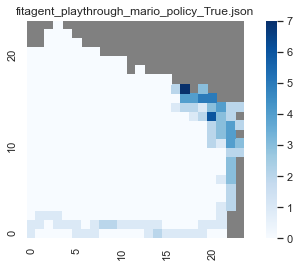

In [14]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

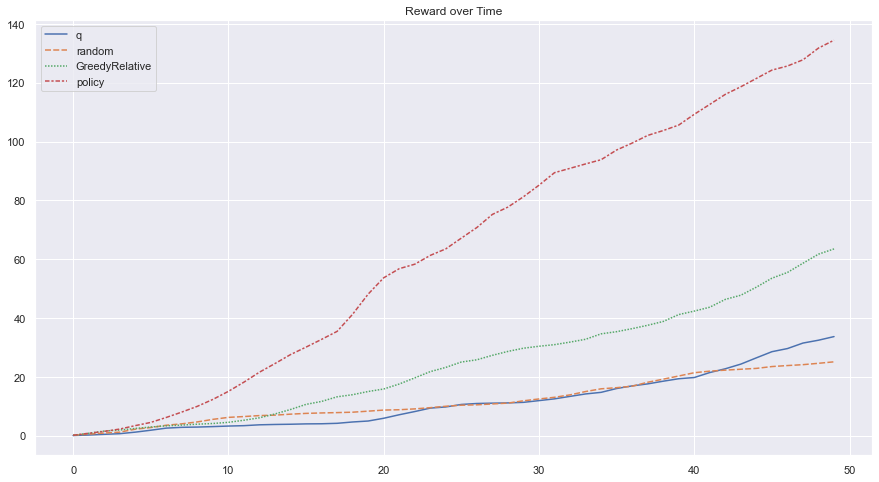

In [15]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [16]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


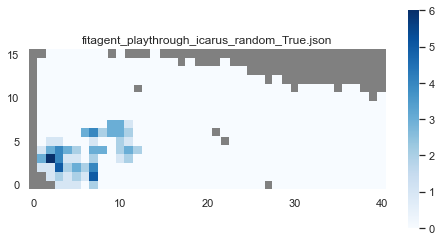

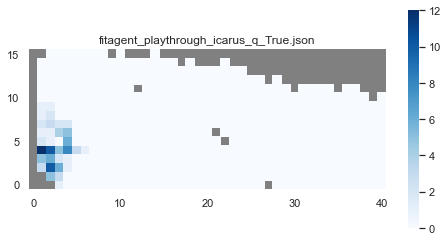

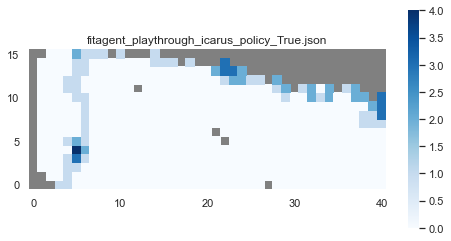

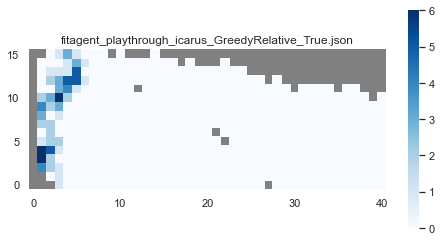

In [17]:
for filename, data in playthroughs:
    heatmap(data, graph, filename, config.MAX_BC)

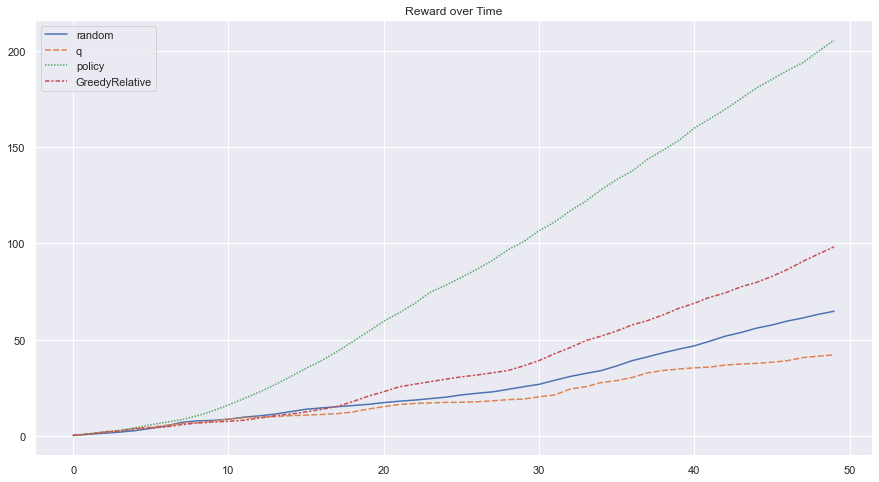

In [18]:
plot_reward_over_time(playthroughs)

# Player Personas

In [19]:
def get_all_player_playthroughs(config, allow_empty_link):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player_*_{allow_empty_link}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-2]

        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [20]:
def plot_player_personas_over_time(playthroughs, player_name):
    plot_data = []
    for player, alg, data in player_playthroughs:
        if player != player_name:
            continue

        for session in data:
            total_reward = 0
            for i, lvl in enumerate(session):
                for _, _, _, r in lvl:
                    total_reward += r

                plot_data.append((alg, i, total_reward))

    plot_df = pd.DataFrame(plot_data, columns=['alg', 'level', 'reward'])
    plot_df.alg.unique()

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_df, x='level', y='reward', hue='alg')
    ax.set_title('Reward over Time')

    plt.show()

# Player Personas :: Mario

In [21]:
def get_df(playthroughs):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Total Reward']
    players = set()
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_total_reward = 0

            for lvl in run:
                for _, percent_complete, player_reward, total_reward in lvl:
                    run_percent_complete += percent_complete
                    run_player_reward += player_reward
                    run_total_reward += total_reward
                    
            data.append((
                director, 
                player, 
                run_percent_complete, 
                run_player_reward, 
                run_total_reward))
            
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', ('Total Reward', 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [22]:
config = Mario
graph = Utility.get_graph(config, True)
player_playthroughs = get_all_player_playthroughs(config, True)
df = get_df(player_playthroughs)
mario_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player likes Hard Levels policy                   64.100  3.523   
                                  GreedyRelative           64.600  2.479   
                                  random                   65.250  3.177   
                                  q                        63.750  2.552   
Mediocre Player Likes High B      policy                   61.750  3.059   
                                  GreedyRelative           63.700  2.105   
                                  random                   65.250  3.177   
                                  q                        63.750  2.268   
Mediocre Player Likes High A      policy                   64.000  2.938   
                                  GreedyRelative           64.100  2.770   
                                  random                   65.250  3.177   
                                  q                        64.600  2.998   
Mediocre Player Likes Easy Levels random                   65.250  3.177   
                                  policy                   62.850  2.033   
                                  q                        64.250  2.573   
                                  GreedyRelative           65.600  2.542   
Good Player Likes Easy Levels     policy                   60.850  0.933   
                                  random                   65.250  3.177   
                                  GreedyRelative           64.200  2.966   
                                  q                        63.450  2.523   
Bad Player Likes Hard Levels      policy                   64.750  3.810   
                                  GreedyRelative           64.500  2.065   
                                  random                   65.250  3.177   
                                  q                        64.950  3.332   
Bad Player Likes Easy Levels      policy                   62.900  2.049   
                                  random                   65.250  3.177   
                                  GreedyRelative           67.450  3.692   
                                  q                        64.950  2.305   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player likes Hard Levels policy                 1.072  0.125   
                                  GreedyRelative         0.427  0.142   
                                  random                 0.325  0.154   
                                  q                      0.266  0.092   
Mediocre Player Likes High B      policy                20.147  4.575   
                                  GreedyRelative        10.227  3.536   
                                  random                 7.446  4.903   
                                  q                      8.467  3.148   
Mediocre Player Likes High A      policy                26.265  5.861   
                                  GreedyRelative        10.929  4.143   
                                  random                 7.518  5.535   
                                  q                      3.726  1.884   
Mediocre Player Likes Easy Levels random                64.925  3.245   
                                  policy                62.350  2.032   
                                  q                     63.916  2.651   
                                  GreedyRelative        65.355  2.596   
Good Player Likes Easy Levels     policy                60.193  0.973   
                                  random                64.925  3.245   
                                  GreedyRelative        63.941  2.986   
                                  q                     63.172  2.597   
Bad Player Li

# Player Personas :: Icarus

In [23]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
icarus_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player likes Hard Levels policy                   76.700  1.949   
                                  GreedyRelative           77.000  3.044   
                                  q                        72.950  3.634   
                                  random                   76.000  2.596   
Mediocre Player Likes High B      policy                   76.700  2.430   
                                  GreedyRelative           76.150  2.870   
                                  q                        73.250  4.494   
                                  random                   76.000  2.596   
Mediocre Player Likes High A      policy                   75.950  2.373   
                                  GreedyRelative           76.400  2.186   
                                  random                   76.000  2.596   
                                  q                        73.900  3.878   
Mediocre Player Likes Easy Levels random                   76.000  2.596   
                                  GreedyRelative           73.550  4.850   
                                  policy                   73.000  4.496   
                                  q                        73.250  3.226   
Good Player Likes Easy Levels     policy                   74.300  2.319   
                                  GreedyRelative           75.600  3.470   
                                  random                   76.000  2.596   
                                  q                        69.600  3.844   
Bad Player Likes Hard Levels      policy                   77.300  2.598   
                                  GreedyRelative           78.100  1.861   
                                  random                   76.000  2.596   
                                  q                        75.950  2.373   
Bad Player Likes Easy Levels      policy                   73.700  3.496   
                                  random                   76.000  2.596   
                                  GreedyRelative           73.900  5.057   
                                  q                        71.250  4.025   

                                                 Player Reward          \
                                                          mean     std   
Player                            Director                               
Mediocre Player likes Hard Levels policy                 0.869   0.203   
                                  GreedyRelative         0.511   0.157   
                                  q                      0.404   0.134   
                                  random                 0.381   0.130   
Mediocre Player Likes High B      policy                 9.539   2.776   
                                  GreedyRelative        10.135   3.510   
                                  q                      7.431   4.323   
                                  random                 7.953   3.078   
Mediocre Player Likes High A      policy                37.890  11.371   
                                  GreedyRelative        18.030   5.598   
                                  random                12.998   7.613   
                                  q                     12.195   7.786   
Mediocre Player Likes Easy Levels random                75.619   2.571   
                                  GreedyRelative        73.149   4.761   
                                  policy                72.532   4.367   
                                  q                     72.886   3.133   
Good Player Likes Easy Levels     policy                73.556   2.259   
                                  GreedyRelative        75.161   3.368   
                                  random                75.619   2.571   
                                  q                     69.293  

# Player Personas :: DungeonGrams

In [24]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_all_player_playthroughs(config, True)
df = get_df(playthroughs)
dg_player_persona_table = df.to_latex() # store in case we want it
df

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


Percent Complete         \
                                                             mean    std   
Player                            Director                                 
Mediocre Player likes Hard Levels policy                   74.200  2.628   
                                  GreedyRelative           79.750  2.268   
                                  random                   79.500  2.212   
                                  q                        77.750  3.740   
Mediocre Player Likes High B      policy                   71.100  3.768   
                                  GreedyRelative           79.750  2.173   
                                  random                   79.500  2.212   
                                  q                        78.000  3.293   
Mediocre Player Likes High A      policy                   74.300  2.736   
                                  GreedyRelative           79.400  2.583   
                                  random                   79.500  2.212   
                                  q                        77.550  3.364   
Mediocre Player Likes Easy Levels random                   79.500  2.212   
                                  q                        77.350  3.329   
                                  GreedyRelative           76.750  3.998   
                                  policy                   68.350  2.277   
Good Player Likes Easy Levels     policy                   71.350  2.700   
                                  random                   79.500  2.212   
                                  q                        77.400  2.062   
                                  GreedyRelative           76.700  3.246   
Bad Player Likes Hard Levels      policy                   77.200  5.297   
                                  GreedyRelative           80.300  2.155   
                                  q                        78.800  2.966   
                                  random                   79.500  2.212   
Bad Player Likes Easy Levels      random                   79.500  2.212   
                                  q                        79.050  2.743   
                                  policy                   69.700  3.629   
                                  GreedyRelative           75.100  3.076   

                                                 Player Reward         \
                                                          mean    std   
Player                            Director                              
Mediocre Player likes Hard Levels policy                 1.180  0.233   
                                  GreedyRelative         0.682  0.229   
                                  random                 0.621  0.252   
                                  q                      0.574  0.182   
Mediocre Player Likes High B      policy                25.846  9.437   
                                  GreedyRelative        16.722  8.904   
                                  random                12.072  7.497   
                                  q                     10.969  5.284   
Mediocre Player Likes High A      policy                28.032  4.722   
                                  GreedyRelative        15.349  9.550   
                                  random                10.292  5.946   
                                  q                      9.629  3.420   
Mediocre Player Likes Easy Levels random                78.879  2.211   
                                  q                     76.762  3.301   
                                  GreedyRelative        76.228  3.867   
                                  policy                67.722  2.225   
Good Player Likes Easy Levels     policy                70.373  2.514   
                                  random                78.879  2.211   
                                  q                     76.801  2.040   
                                  GreedyRelative        76.167  3.165   
Bad Player Li